In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_dir = "./data"

device = torch.device("cpu")

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

if torch.cuda.is_available():
    device = torch.device("cuda")

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : mps


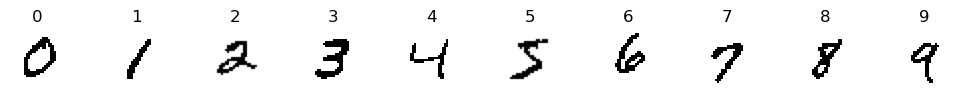

In [46]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# load MNIST and convert it to binary directly in transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),               # normalize to [0, 1]
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

sample_list = [(label, next(image for image, lbl in train_dataset if lbl == label)) for label in range(10)]
print_samples(sample_list)

In [47]:
class RBM(nn.Module):
    def __init__(self, visible_dim, hidden_dim=128, W_var=0.01, a_val=0.0, b_val=0.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(visible_dim, hidden_dim) * W_var)
        self.a = nn.Parameter(torch.full((visible_dim,), a_val))
        self.b = nn.Parameter(torch.full((hidden_dim,), b_val))

    def sample_hidden(self, v):
        h_probs = torch.sigmoid(v @ self.W + self.b)
        h_sample = torch.bernoulli(h_probs)
        return h_probs, h_sample

    def sample_visible(self, h):
        v_probs = torch.sigmoid(h @ self.W.t() + self.a)
        v_sample = torch.bernoulli(v_probs)
        return v_probs, v_sample

    def sample_gibbs(self, v, k=1):
        vk_probs = torch.zeros_like(v)
        vk_sample = v.clone()
        for _ in range(k):
            _, hk_sample = self.sample_hidden(vk_sample)
            vk_probs, vk_sample = self.sample_visible(hk_sample)
        return vk_probs, vk_sample

    def contrastive_divergence(self, v0, k=1, lr=0.01):
        # positive phase
        h0_probs, h0_sample = self.sample_hidden(v0)

        # negative phase
        _, vk = self.sample_gibbs(v0, k)

        # calculate associations
        positive_association = v0.t() @ h0_probs
        negative_association = vk.t() @ torch.sigmoid(vk @ self.W + self.b)

        # parameter step
        self.W.data += lr * (positive_association - negative_association) / v0.size(0)
        self.a.data += lr * (v0.mean(dim=0) - vk.mean(dim=0))
        self.b.data += lr * (h0_probs.mean(dim=0) - torch.sigmoid(vk @ self.W + self.b).mean(dim=0))

        return vk

In [4]:
hidden_dim = 128
batch_size = 32
epochs = 5
lr = 0.01
gibbs_steps = 1


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


visible_dim = train_dataset[0][0].numel()
rbm = RBM(visible_dim, hidden_dim).to(device)


metrics = {}
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch, _ in train_loader:
        flat_batch = batch.view(-1, visible_dim).to(device)

        recon_batch = rbm.contrastive_divergence(flat_batch, k=gibbs_steps)

        loss = torch.mean(torch.sum((flat_batch - recon_batch) ** 2, dim=1))
        epoch_loss += loss.item()

    metrics[epoch] = { "reconstruction_error": epoch_loss / len(train_loader) }
    print(f"Epoch {epoch + 1}/{epochs} : Loss {metrics[epoch]['reconstruction_error']:.4f}")

Epoch 1/5 : Loss 114.7604
Epoch 2/5 : Loss 81.1539
Epoch 3/5 : Loss 71.5484
Epoch 4/5 : Loss 66.0311
Epoch 5/5 : Loss 62.3051


Text(0, 0.5, 'Reconstruction Error')

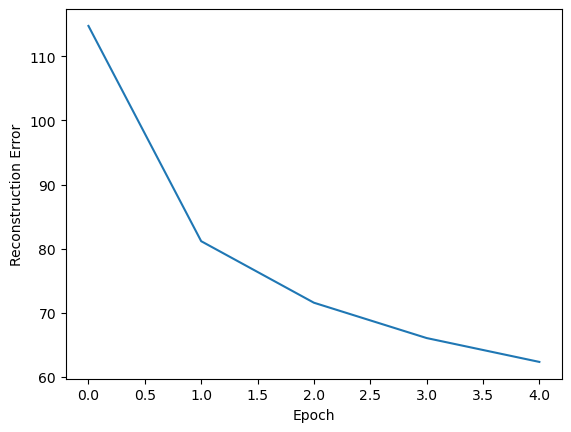

In [48]:
# only plot the reconstruction_error
plt.plot([metrics[epoch]['reconstruction_error'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

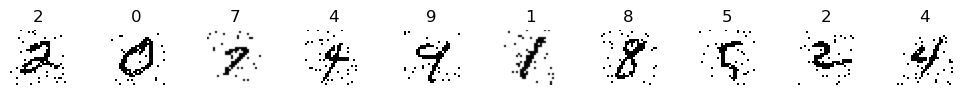

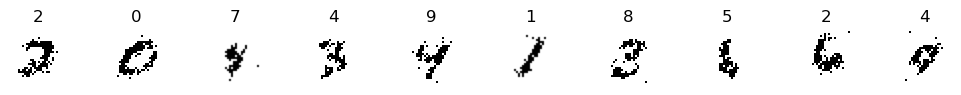

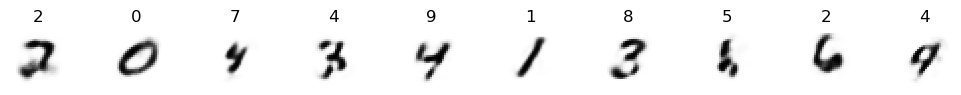

In [55]:
# getting some random samples with noise
random_labels = torch.randint(0, 10, (10,))
noise_level = 0.05

demo_samples = []
label_idx = 0

for image, lbl in train_dataset:
    if label_idx >= len(random_labels):
        break

    if lbl == random_labels[label_idx]:
        demo_samples.append((lbl, image))

        noise = torch.rand_like(image)
        image[noise < noise_level] = 1 - image[noise < noise_level]

        label_idx += 1


# performing reconstruction
demo_recon_probs = []
demo_recon_samples = []
with torch.no_grad():
    for digit, sample in demo_samples:
        flat_sample = sample.view(-1, visible_dim).to(device)

        v_probs, v_sample = rbm.sample_gibbs(flat_sample, k=10)

        demo_recon_probs.append((digit, v_probs.view(28, 28).cpu()))
        demo_recon_samples.append((digit, v_sample.view(28, 28).cpu()))


inverted_demo_recon_probs = [(digit, 1 - v_prob) for digit, v_prob in demo_recon_probs]

print_samples(demo_samples, elements_per_row=10, cmap="binary")
print_samples(demo_recon_samples, elements_per_row=10, cmap="binary")
print_samples(inverted_demo_recon_probs, elements_per_row=10, cmap="gray")